## Яндекс Практикум, курс "Инженер Машинного Обучения" (2024 г.)
## Проект 2-го спринта: "Улучшение baseline-модели"

__Содержание__:

* [Этап 2: Проведение EDA](#step_2)
* [Этап 3: Генерация признаков и обучение модели](#step_3)
* [Этап 4: Отбор признаков и обучение новой версии модели](#step_4)
* [Этап 5: Подбор гиперпараметров и обучение новой версии модели](#step_5)

In [1]:
import os
from dotenv import load_dotenv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import psycopg2 as psycopg
from sqlalchemy import create_engine
from datetime import datetime
import time

from category_encoders import CatBoostEncoder
from catboost import CatBoostRegressor

import mlflow
from mlflow.utils.mlflow_tags import MLFLOW_PARENT_RUN_ID

from collections import defaultdict
from statistics import median

from sklearn.metrics import mean_absolute_percentage_error
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold, train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import (
    StandardScaler,
    OneHotEncoder, 
    SplineTransformer, 
    QuantileTransformer, 
    RobustScaler,
    PolynomialFeatures,
    KBinsDiscretizer,
    FunctionTransformer
)

from autofeat import AutoFeatRegressor

from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs

import optuna
from optuna.integration.mlflow import MLflowCallback

In [2]:
np.random.seed(42)

Загружаем переменные окружения

In [3]:
load_dotenv()

True

### Этап 2: Проведение EDA <a id="step_2"></a>

После выполнения EDA логируем его результаты, включая ноутбук с кодом EDA "notebook_eda.ipynb" и md-файл с выводами "conclusions_eda.md"

In [6]:
os.environ["MLFLOW_S3_ENDPOINT_URL"] = "https://storage.yandexcloud.net" 
os.environ["AWS_ACCESS_KEY_ID"] = os.getenv("AWS_ACCESS_KEY_ID") 
os.environ["AWS_SECRET_ACCESS_KEY"] = os.getenv("AWS_SECRET_ACCESS_KEY") 

TRACKING_SERVER_HOST = '127.0.0.1' 
TRACKING_SERVER_PORT = 5000

mlflow.set_tracking_uri(f"http://{TRACKING_SERVER_HOST}:{TRACKING_SERVER_PORT}")
mlflow.set_registry_uri(f"http://{TRACKING_SERVER_HOST}:{TRACKING_SERVER_PORT}") 

EXPERIMENT_NAME = 'mle-project-sprint-2'
RUN_NAME = 'step_2'

In [7]:
experiment_id = mlflow.get_experiment_by_name(EXPERIMENT_NAME).experiment_id

with mlflow.start_run(run_name=RUN_NAME, experiment_id=experiment_id) as run:
    run_id = run.info.run_id
    mlflow.log_artifact("notebook_eda.ipynb", "eda")
    mlflow.log_artifact("conclusions_eda.md", "eda")

In [8]:
print(run_id)

run = mlflow.get_run(run_id)
assert run.info.status == 'FINISHED'

dda6cd831cf14ed3a90b275be16cdc63


__Выводы по результатам 2-го этапа__

См. файлы notebook_eda.ipynb или conclusions_eda.md.

### Этап 3: Генерация признаков и обучение модели <a id="step_3"></a>

__Извлекаем очищенные данные__

In [4]:
# Загружаем параметры подключения к БД из переменных окружения
username = os.environ.get('DB_DESTINATION_USER')
password = os.environ.get('DB_DESTINATION_PASSWORD')
host = os.environ.get('DB_DESTINATION_HOST')
port = os.environ.get('DB_DESTINATION_PORT')
db = os.environ.get('DB_DESTINATION_NAME')

In [5]:
# Создаем соединение к БД
conn = create_engine(f'postgresql://{username}:{password}@{host}:{port}/{db}', connect_args={'sslmode':'require'})

In [6]:
# Скачиваем данные из таблицы clean_flats_dataset в датафрейм
data = pd.read_sql('select * from clean_flats_dataset', conn, index_col='flat_id')

In [7]:
data.head()

,id,floor,kitchen_area,living_area,rooms,is_apartment,studio,total_area,price,build_year,building_type_int,latitude,longitude,ceiling_height,flats_count,floors_total,has_elevator
flat_id,,,,,,,,,,,,,,,,,
8348,23114,8,10.6,56.000000,3,False,False,88.599998,10990000,2018,4,55.542187,37.483067,2.64,409,18,True
8350,23116,3,7.0,28.000000,2,False,False,44.700001,8999000,1967,4,55.857765,37.422684,2.64,143,9,True
8351,23118,16,10.9,54.799999,4,False,False,89.099998,24000000,1996,4,55.562908,37.570431,2.70,164,16,True
8352,23120,2,7.4,66.300003,4,False,False,93.000000,17500000,1965,1,55.653507,37.649426,2.70,59,6,True
8354,23122,4,9.1,17.700001,1,False,False,34.000000,7500000,1964,1,55.796406,37.459873,3.00,72,9,True


Выполняем ту же предобработку, что и в проекте 1-го спринта

In [8]:
# Вместо года постройки добавляем возраст здания
data['building_age'] = (datetime.now().year - data['build_year']).astype('float')

# Удаляем лишние колонки (studio является константным признаком, см. EDA)
data.drop(
    columns=['id', 'build_year', 'studio'], 
    inplace=True
)

# Изменяем тип целочисленных признаков rooms и building_type_int на object, чтобы работать с ними как с категориальными
data[['rooms', 'building_type_int']] = data[['rooms', 'building_type_int']].astype('object')

# Изменяем тип целых колонок на float
num_int_cols = data.select_dtypes('int').columns
data[num_int_cols] = data[num_int_cols].astype('float') 

__Генерируем новые признаки и обучаем модель__

Разделяем данные на обучающую и тестовую выборки

In [9]:
X_train, X_test, y_train, y_test = train_test_split(data[data.columns.drop('price')],
                                                    data['price'], 
                                                    test_size=0.2, 
                                                    random_state=42
                                                   )

Группируем признаки по типам

In [10]:
cat_features = X_train.select_dtypes(include=['bool', 'object'])
is_bin_cat_features = cat_features.nunique() == 2
bin_cat_features = cat_features[is_bin_cat_features[is_bin_cat_features].index]
other_cat_features = cat_features[is_bin_cat_features[~is_bin_cat_features].index]
num_features = X_train.select_dtypes(include=['float'])

Создаем энкодеры для кодирования существующих и генерации новых признаков

In [11]:
# Для бинарных признаков
encoder_oh = OneHotEncoder(
    categories='auto',
    handle_unknown='ignore', 
    sparse_output=False,
    drop='if_binary'
) 

# Для небинарных категориальных признаков
encoder_cb = CatBoostEncoder(random_state=42)

# Для генерации новых числовых признаков
encoder_pol = PolynomialFeatures(
    degree=2,
    include_bias=False
)

# Для генерации новых числовых признаков
encoder_kbd = KBinsDiscretizer(
    n_bins=3, 
    encode='ordinal', 
    strategy='uniform', 
    subsample=None,
    random_state=42
)

# Для генерации новых числовых признаков
encoder_q = QuantileTransformer(
    n_quantiles=100,
    random_state=42
)

# Для генерации новых числовых признаков
# А именно, применяем к каждому числовому признаку функцию log(1+x) один раз
encoder_afr = AutoFeatRegressor(
    transformations=('1+', 'log'),
    feateng_steps=1,
    n_jobs=-1
)

Создаем основной трансформер данных с autofeat (его мы объединим в один пайплайн с моделью)

In [12]:
# Применяем выбранные преобразования к числовым признакам (в т.ч. autofeat)
num_preproc_w_afr = ColumnTransformer(
    [
        ('num_pol', encoder_pol, num_features.columns.tolist()),
        ('num_q', encoder_q, num_features.columns.tolist()),
        ('num_afr', encoder_afr, num_features.columns.tolist()) 
    ],
    remainder='drop',
    verbose_feature_names_out=True,
    n_jobs=-1
)

# Нормализуем числовые признаки после их преобразования.
# На выходе полиномиального энкодера будут в т.ч. исходные числовые признаки, им соответствует степень 1
num_pipeline_w_afr = Pipeline(
    [
        ('num_preproc_w_afr', num_preproc_w_afr),
        ('num_sc', StandardScaler())
    ]
)

# Добавляем к числовому пайплайну энкодеры категориальных признаков
preproc_w_afr = ColumnTransformer(
    [
        ('bin_cat', encoder_oh, bin_cat_features.columns.tolist()),
        ('other_cat', encoder_cb, other_cat_features.columns.tolist()),
        ('num_pipeline_w_afr', num_pipeline_w_afr, num_features.columns.tolist())
        
    ],
    remainder='drop',
    verbose_feature_names_out=True,
    n_jobs=-1
)

Создаем вспомогательный трансформер данных без autofeat (чтобы воспользоваться get_features_names_out, когда будем сохранять преобразованные признаки с их именами)

In [13]:
# Применяем выбранные преобразования к числовым признакам (исключая autofeat)
num_preproc_wo_afr = ColumnTransformer(
    [
        ('num_pol', encoder_pol, num_features.columns.tolist()),
        ('num_q', encoder_q, num_features.columns.tolist())
    ],
    remainder='drop',
    verbose_feature_names_out=True,
    n_jobs=-1
)

# Нормализуем числовые признаки после их преобразования.
# На выходе полиномиального энкодера будут в т.ч. исходные числовые признаки, им соответствует степень 1
num_pipeline_wo_afr = Pipeline(
    [
        ('num_preproc_wo_afr', num_preproc_wo_afr),
        ('num_sc', StandardScaler())
    ]
)

# Добавляем к числовому пайплайну энкодеры категориальных признаков
preproc_wo_afr = ColumnTransformer(
    [
        ('bin_cat', encoder_oh, bin_cat_features.columns.tolist()),
        ('other_cat', encoder_cb, other_cat_features.columns.tolist()),
        ('num_pipeline_wo_afr', num_pipeline_wo_afr, num_features.columns.tolist())
        
    ],
    remainder='drop',
    verbose_feature_names_out=True,
    n_jobs=-1
)

Создаем пайплайн из модели и основного трансформера, включающего autofeat

In [14]:
# Создаем модель с параметрами по умолчанию
model = CatBoostRegressor(loss_function='MAPE', verbose=False, random_state=42)
  
# Финальный пайплайн
pipeline = Pipeline(
    [
        ('preproc_w_afr', preproc_w_afr),
        ('model', model)
    ]
)

In [17]:
# Структура пайплайна
pipeline

Pipeline(steps=[('preproc_w_afr',
                 ColumnTransformer(n_jobs=-1,
                                   transformers=[('bin_cat',
                                                  OneHotEncoder(drop='if_binary',
                                                                handle_unknown='ignore',
                                                                sparse_output=False),
                                                  ['is_apartment',
                                                   'has_elevator']),
                                                 ('other_cat',
                                                  CatBoostEncoder(random_state=42),
                                                  ['rooms',
                                                   'building_type_int']),
                                                 ('num_pipeline_w_afr',
                                                  Pipeline(steps=[('num_preproc_w_afr',
                                                                   ColumnTransformer(n...
                                                                                                     'living_area',
                                                                                                     'total_area',
                                                                                                     'latitude',
                                                                                                     'longitude',
                                                                                                     'ceiling_height',
                                                                                                     'flats_count',
                                                                                                     'floors_total',
                                                                                                     'building_age'])])),
                                                                  ('num_sc',
                                                                   StandardScaler())]),
                                                  ['floor', 'kitchen_area',
                                                   'living_area', 'total_area',
                                                   'latitude', 'longitude',
                                                   'ceiling_height',
                                                   'flats_count',
                                                   'floors_total',
                                                   'building_age'])])),
                ('model',
                 <catboost.core.CatBoostRegressor object at 0x7fc070250f70>)])

Запускаем пайплайн на обучающих данных

In [ ]:
start = time.time()
pipeline.fit(X_train, y_train)
end = time.time()

Оцениваем модель на тестовых данных

In [16]:
y_pred = pipeline.predict(X_test)
mape = mean_absolute_percentage_error(y_test, y_pred)

metrics = {}
metrics['MAPE'] = mape
metrics['fit_time'] = end - start
print(metrics)

{'MAPE': 1.225445433359022, 'fit_time': 83.56170749664307}


__Сохраняем преобразованные данные для логирования в MLflow и использования на последующих этапах__

In [17]:
# Признаки, сгенерированные без autofeat (на выходе будет ndarray)
encoded_X_train_wo_afr = preproc_wo_afr.fit_transform(X_train, y_train) 
encoded_X_test_wo_afr = preproc_wo_afr.transform(X_test)

# Превращаем их в dataframe
encoded_X_train_wo_afr = pd.DataFrame(
    encoded_X_train_wo_afr, 
    columns=preproc_wo_afr.get_feature_names_out()
) 

encoded_X_test_wo_afr = pd.DataFrame(
    encoded_X_test_wo_afr, 
    columns=preproc_wo_afr.get_feature_names_out()
)

In [20]:
# Смотрим, что получилось
encoded_X_train_wo_afr.head()

,bin_cat__is_apartment_True,bin_cat__has_elevator_True,other_cat__rooms,other_cat__building_type_int,num_pipeline_wo_afr__num_pol__floor,num_pipeline_wo_afr__num_pol__kitchen_area,num_pipeline_wo_afr__num_pol__living_area,num_pipeline_wo_afr__num_pol__total_area,num_pipeline_wo_afr__num_pol__latitude,num_pipeline_wo_afr__num_pol__longitude,...,num_pipeline_wo_afr__num_q__floor,num_pipeline_wo_afr__num_q__kitchen_area,num_pipeline_wo_afr__num_q__living_area,num_pipeline_wo_afr__num_q__total_area,num_pipeline_wo_afr__num_q__latitude,num_pipeline_wo_afr__num_q__longitude,num_pipeline_wo_afr__num_q__ceiling_height,num_pipeline_wo_afr__num_q__flats_count,num_pipeline_wo_afr__num_q__floors_total,num_pipeline_wo_afr__num_q__building_age
0,0.0,1.0,1.274040e+07,1.274040e+07,-1.052174,-0.692780,-0.299733,-0.847382,1.588429,-0.438656,...,-1.192165,-1.054159,-0.301378,-1.039578,1.648781,-0.496144,-1.519512,-1.242884,-0.181963,0.792346
1,0.0,1.0,1.107020e+07,1.274040e+07,0.055965,-0.692780,-0.063449,-0.491669,-0.422046,0.851233,...,0.308035,-1.054159,-0.161198,-0.394518,-0.440684,0.932541,-0.505474,0.775025,-0.866801,0.511058
2,0.0,1.0,1.001347e+07,1.032020e+07,-0.608918,-0.366908,-1.886207,-0.240921,0.530116,-0.070656,...,-0.544351,-0.553734,-1.650011,-0.048742,0.528656,0.025349,0.633094,-0.184500,-0.866801,0.915409
3,0.0,1.0,1.213510e+07,1.274040e+07,-1.052174,2.240064,1.151722,1.024484,-0.262148,-0.614266,...,-1.192165,1.689550,1.276860,1.139680,-0.251038,-0.724741,1.718292,1.603705,1.012112,-1.018440
4,0.0,1.0,1.542808e+07,1.304680e+07,0.499221,-0.725367,-0.002691,-0.480007,-1.143133,-0.044685,...,0.751275,-1.295743,-0.104803,-0.371272,-1.255525,0.077451,-0.505474,0.129527,-0.866801,0.686863


In [18]:
# Количество и имена новых признаков без использования autofeat
print(len(preproc_wo_afr.get_feature_names_out()))
print(preproc_wo_afr.get_feature_names_out())

79
['bin_cat__is_apartment_True' 'bin_cat__has_elevator_True'
 'other_cat__rooms' 'other_cat__building_type_int'
 'num_pipeline_wo_afr__num_pol__floor'
 'num_pipeline_wo_afr__num_pol__kitchen_area'
 'num_pipeline_wo_afr__num_pol__living_area'
 'num_pipeline_wo_afr__num_pol__total_area'
 'num_pipeline_wo_afr__num_pol__latitude'
 'num_pipeline_wo_afr__num_pol__longitude'
 'num_pipeline_wo_afr__num_pol__ceiling_height'
 'num_pipeline_wo_afr__num_pol__flats_count'
 'num_pipeline_wo_afr__num_pol__floors_total'
 'num_pipeline_wo_afr__num_pol__building_age'
 'num_pipeline_wo_afr__num_pol__floor^2'
 'num_pipeline_wo_afr__num_pol__floor kitchen_area'
 'num_pipeline_wo_afr__num_pol__floor living_area'
 'num_pipeline_wo_afr__num_pol__floor total_area'
 'num_pipeline_wo_afr__num_pol__floor latitude'
 'num_pipeline_wo_afr__num_pol__floor longitude'
 'num_pipeline_wo_afr__num_pol__floor ceiling_height'
 'num_pipeline_wo_afr__num_pol__floor flats_count'
 'num_pipeline_wo_afr__num_pol__floor floors_to

In [19]:
# Признаки, полученные только с помощью autofeat
encoded_X_train_afr = encoder_afr.fit_transform(X_train[num_features.columns].values, y_train.values)
encoded_X_test_afr = encoder_afr.transform(X_test[num_features.columns].values)

/home/mle-user/mle_projects/mle-mlflow/.venv_mle_mlflow/lib/python3.10/site-packages/autofeat/featsel.py:270: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  if np.max(np.abs(correlations[c].ravel()[:i])) < 0.9:


In [23]:
# Смотрим, что получилось при использовании autofeat
encoded_X_train_afr.head()

,x000,x001,x002,x003,x004,x005,x006,x007,x008,x009
0,2.0,6.0,23.5,37.900002,55.891251,37.538116,2.50,82.0,12.0,55.0
1,7.0,6.0,27.0,44.000000,55.685341,37.728146,2.64,287.0,9.0,52.0
2,4.0,7.0,0.0,48.299999,55.782860,37.592331,2.70,179.0,9.0,56.0
3,2.0,15.0,45.0,70.000000,55.701717,37.512245,3.00,512.0,17.0,19.0
4,9.0,5.9,27.9,44.200001,55.611488,37.596157,2.64,211.0,9.0,54.0


In [20]:
# Объединяем все признаки
encoded_X_train = pd.concat([encoded_X_train_wo_afr, encoded_X_train_afr], axis=1)
encoded_X_test = pd.concat([encoded_X_test_wo_afr, encoded_X_test_afr], axis=1)

In [ ]:
# Добавляем целевую переменную и сохраняем в файлы

encoded_data_train = pd.concat([encoded_X_train, y_train], axis=1)
encoded_data_test = pd.concat([encoded_X_test, y_test], axis=1)

os.makedirs('../data', exist_ok=True)
encoded_data_train.to_csv('../data/encoded_data_train.csv')
encoded_data_test.to_csv('../data/encoded_data_test.csv')

__Логируем результаты в MLflow__

Устанавливаем параметры MLflow Tracking Server и MLflow Model Registry, а также идентификаторы эксперимента, запуска и модели
(сначала нужно поднять MLflow, для чего в терминале перейти в папку mlflow_server и выполнить в командной строке 
 команду "sh run_mlflow_server.sh")

In [58]:
os.environ["MLFLOW_S3_ENDPOINT_URL"] = "https://storage.yandexcloud.net" 
os.environ["AWS_ACCESS_KEY_ID"] = os.getenv("AWS_ACCESS_KEY_ID") 
os.environ["AWS_SECRET_ACCESS_KEY"] = os.getenv("AWS_SECRET_ACCESS_KEY") 

TRACKING_SERVER_HOST = '127.0.0.1' 
TRACKING_SERVER_PORT = 5000

mlflow.set_tracking_uri(f"http://{TRACKING_SERVER_HOST}:{TRACKING_SERVER_PORT}")
mlflow.set_registry_uri(f"http://{TRACKING_SERVER_HOST}:{TRACKING_SERVER_PORT}") 

EXPERIMENT_NAME = 'mle-project-sprint-2'
RUN_NAME = 'step_3'
REGISTRY_MODEL_NAME = 'flats_price_model_sprint_2_step_3'

Оборачиваем пайплайн в класс CustomMlflowModel для логирования в MLflow

In [59]:
class CustomMlflowModel(mlflow.pyfunc.PythonModel):
    def __init__(self, model):
        super().__init__()
        self._model = model
    
    def predict(self, context, model_input):
        return self._model.predict(model_input)

In [60]:
custom_model = CustomMlflowModel(pipeline)

Логируем модель, энкодер autofeat, метрики и другие артефакты в MLflow

In [61]:
metadata = {'model_type': 'regression'}
pip_requirements = "../requirements.txt" 
signature = mlflow.models.infer_signature(
    X_test,
    pipeline.predict(X_test)
) 
input_example = data[:10]

experiment_id = mlflow.get_experiment_by_name(EXPERIMENT_NAME).experiment_id

with mlflow.start_run(run_name=RUN_NAME, experiment_id=experiment_id) as run:
    run_id = run.info.run_id
    
    mlflow.log_metrics(metrics)
    mlflow.log_artifact("../data/encoded_data_train.csv", "data")
    mlflow.log_artifact("../data/encoded_data_test.csv", "data")
            
    model_info = mlflow.pyfunc.log_model( 
        python_model=custom_model,
        artifact_path="models",
        registered_model_name=REGISTRY_MODEL_NAME,
        metadata=metadata,
        signature=signature,
        input_example=input_example,
        pip_requirements=pip_requirements
    )
    
    afr_info = mlflow.sklearn.log_model(
        encoder_afr, 
        artifact_path="encoders",
        registered_model_name='encoder_afr_sprint_2_step_3'
    )

/home/mle-user/mle_projects/mle-mlflow/.venv_mle_mlflow/lib/python3.10/site-packages/mlflow/models/signature.py:212: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input) if model_input is not None else None
Successfully registered model 'flats_price_model_sprint_2_step_3'.
2024/04/20 13:41:55 INFO mlflow.tracking._model_registry.client: Waiting 

In [62]:
print(run_id)

run = mlflow.get_run(run_id)
assert run.info.status == 'FINISHED'

85f646eecd7047b5ac5e253aa54bcf04


__Выводы по результатам 3-го этапа__

Благодаря добавлению новых признаков ошибка MAPE на тестовых данных немного уменьшилась по сравнению с базовой моделью из 1-го этапа, время обучения при этом выросло.

### Этап 4: Отбор признаков и обучение новой версии модели <a id="step_4"></a>

Будем использовать преобразованные признаки из предыдущего этапа.

Создаем папку для хранения артефактов, относящихся к отбору признаков

In [25]:
FS_ASSETS_DIR = "fs_assets"
os.makedirs(f'../{FS_ASSETS_DIR}', exist_ok=True)

__Отбираем признаки с помощью метода Sequential Forward Floating Selection (SFFS)__

In [ ]:
model = CatBoostRegressor(
    iterations=10, 
    loss_function='MAPE', 
    eval_metric='MAPE', 
    verbose=False, 
    random_state=42
)

# Отбираем 10 признаков, критерий качества задается в самой модели
sffs = SFS(
    estimator=model,
    forward=True,      
    floating=True,
    k_features=10,
    scoring='neg_mean_absolute_percentage_error',
    cv=2,               
    n_jobs=-1
) 

sffs = sffs.fit(encoded_X_train, y_train)
sffs_df = pd.DataFrame.from_dict(sffs.get_metric_dict()).T
sffs_df.to_csv(f"../{FS_ASSETS_DIR}/sbs.csv")

In [84]:
sffs_df

,feature_idx,cv_scores,avg_score,feature_names,ci_bound,std_dev,std_err
1,"(82,)","[-1.0015730265551546, -0.9999193668018812]",-1.000746,"(x003,)",0.003558,0.000827,0.000827
2,"(0, 82)","[-1.0030822543849605, -0.9916119713944131]",-0.997347,"(bin_cat__is_apartment_True, x003)",0.024676,0.005735,0.005735
3,"(0, 2, 82)","[-0.9950923215478769, -1.0214780921577904]",-1.008285,"(bin_cat__is_apartment_True, other_cat__rooms,...",0.056764,0.013193,0.013193
4,"(0, 7, 41, 82)","[-1.2757326907424622, -0.9901173276543979]",-1.132925,"(bin_cat__is_apartment_True, num_pipeline_wo_a...",0.614452,0.142808,0.142808
5,"(0, 7, 41, 55, 82)","[-1.2058733673163597, -0.9952923188679704]",-1.100583,"(bin_cat__is_apartment_True, num_pipeline_wo_a...",0.453029,0.105291,0.105291
6,"(0, 7, 35, 41, 55, 82)","[-1.9303479374972714, -1.4235295506447678]",-1.676939,"(bin_cat__is_apartment_True, num_pipeline_wo_a...",1.090332,0.253409,0.253409
7,"(0, 1, 7, 35, 41, 55, 82)","[-1.7751358389448129, -1.4692046011863358]",-1.62217,"(bin_cat__is_apartment_True, bin_cat__has_elev...",0.658158,0.152966,0.152966
8,"(0, 1, 7, 8, 35, 41, 55, 82)","[-1.9690911663999053, -1.8318297727726063]",-1.90046,"(bin_cat__is_apartment_True, bin_cat__has_elev...",0.295294,0.068631,0.068631
9,"(0, 1, 7, 8, 35, 41, 55, 70, 82)","[-1.8380730178441467, -0.9922462928645441]",-1.41516,"(bin_cat__is_apartment_True, bin_cat__has_elev...",1.819649,0.422913,0.422913
10,"(0, 1, 7, 8, 26, 35, 41, 55, 70, 82)","[-1.876279649721362, -1.413019652213439]",-1.64465,"(bin_cat__is_apartment_True, bin_cat__has_elev...",0.996623,0.23163,0.23163


In [85]:
print(sffs.k_score_)
print(sffs.k_feature_names_)
print(sffs.k_feature_idx_)

-1.6446496509674007
('bin_cat__is_apartment_True', 'bin_cat__has_elevator_True', 'num_pipeline_wo_afr__num_pol__total_area', 'num_pipeline_wo_afr__num_pol__latitude', 'num_pipeline_wo_afr__num_pol__kitchen_area total_area', 'num_pipeline_wo_afr__num_pol__living_area latitude', 'num_pipeline_wo_afr__num_pol__total_area^2', 'num_pipeline_wo_afr__num_pol__longitude ceiling_height', 'num_pipeline_wo_afr__num_q__kitchen_area', 'x003')
(0, 1, 7, 8, 26, 35, 41, 55, 70, 82)


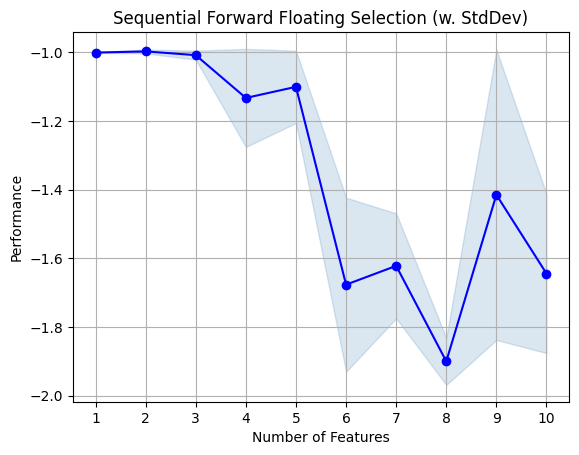

<Figure size 640x480 with 0 Axes>

In [86]:
# График отбора признаков для SFFS
fig = plot_sfs(sffs.get_metric_dict(), kind='std_dev')
plt.title('Sequential Forward Floating Selection (w. StdDev)')
plt.grid()
plt.show()
plt.savefig(f"../{FS_ASSETS_DIR}/sffs.png")

На графике видно, что наилучшая производительность достигается при использовани 4-х параметров.

__Отбираем признаки с помощью метода Sequential Forward Selection (SFS)__

In [ ]:
model = CatBoostRegressor(
    iterations=10, 
    loss_function='MAPE', 
    eval_metric='MAPE', 
    verbose=False, 
    random_state=42
)

# Отбираем 10 признаков
sfs = SFS(
    estimator=model,
    forward=True,      
    floating=False,
    k_features=10,
    scoring='neg_mean_absolute_percentage_error',
    cv=2,               
    n_jobs=-1
) 

sfs = sfs.fit(encoded_X_train, y_train)
sfs_df = pd.DataFrame.from_dict(sfs.get_metric_dict()).T
sfs_df.to_csv(f"../{FS_ASSETS_DIR}/sfs.csv")

In [80]:
sfs_df

,feature_idx,cv_scores,avg_score,feature_names,ci_bound,std_dev,std_err
1,"(82,)","[-1.0015730265551546, -0.9999193668018812]",-1.000746,"(x003,)",0.003558,0.000827,0.000827
2,"(0, 82)","[-1.0030822543849605, -0.9916119713944131]",-0.997347,"(bin_cat__is_apartment_True, x003)",0.024676,0.005735,0.005735
3,"(0, 2, 82)","[-0.9950923215478769, -1.0214780921577904]",-1.008285,"(bin_cat__is_apartment_True, other_cat__rooms,...",0.056764,0.013193,0.013193
4,"(0, 2, 7, 82)","[-0.9833796337543638, -3.909388723653463]",-2.446384,"(bin_cat__is_apartment_True, other_cat__rooms,...",6.2948,1.463005,1.463005
5,"(0, 2, 7, 41, 82)","[-0.9868158801264777, -1.8666168149516194]",-1.426716,"(bin_cat__is_apartment_True, other_cat__rooms,...",1.892739,0.4399,0.4399
6,"(0, 2, 7, 41, 43, 82)","[-0.9828403079827904, -1.003067283275137]",-0.992954,"(bin_cat__is_apartment_True, other_cat__rooms,...",0.043515,0.010113,0.010113
7,"(0, 2, 6, 7, 41, 43, 82)","[-1.6402762555715784, -3.2117147156203725]",-2.425995,"(bin_cat__is_apartment_True, other_cat__rooms,...",3.380677,0.785719,0.785719
8,"(0, 2, 6, 7, 29, 41, 43, 82)","[-1.6441336057823615, -1.0329743168221004]",-1.338554,"(bin_cat__is_apartment_True, other_cat__rooms,...",1.314803,0.30558,0.30558
9,"(0, 2, 4, 6, 7, 29, 41, 43, 82)","[-1.767213241717813, -1.0023069989207574]",-1.38476,"(bin_cat__is_apartment_True, other_cat__rooms,...",1.645563,0.382453,0.382453
10,"(0, 2, 4, 6, 7, 29, 34, 41, 43, 82)","[-1.6298647996986708, -2.1456349145705746]",-1.88775,"(bin_cat__is_apartment_True, other_cat__rooms,...",1.10959,0.257885,0.257885


In [81]:
print(sfs.k_score_)
print(sfs.k_feature_names_)
print(sfs.k_feature_idx_)

-1.8877498571346227
('bin_cat__is_apartment_True', 'other_cat__rooms', 'num_pipeline_wo_afr__num_pol__floor', 'num_pipeline_wo_afr__num_pol__living_area', 'num_pipeline_wo_afr__num_pol__total_area', 'num_pipeline_wo_afr__num_pol__kitchen_area ceiling_height', 'num_pipeline_wo_afr__num_pol__living_area total_area', 'num_pipeline_wo_afr__num_pol__total_area^2', 'num_pipeline_wo_afr__num_pol__total_area longitude', 'x003')
(0, 2, 4, 6, 7, 29, 34, 41, 43, 82)


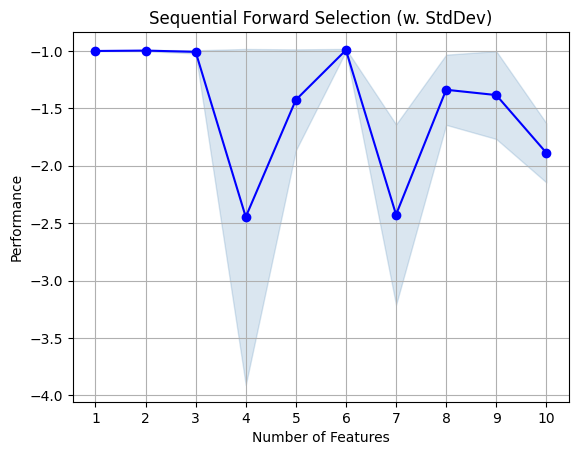

<Figure size 640x480 with 0 Axes>

In [82]:
# График отбора признаков для SFS
fig = plot_sfs(sfs.get_metric_dict(), kind='std_dev')
plt.title('Sequential Forward Selection (w. StdDev)')
plt.grid()
plt.show()
plt.savefig(f"../{FS_ASSETS_DIR}/sfs.png")

Из графика следует, что наилучшая производительность достигается также при использовании 4-х признаков.

__Обучаем модель на отобранных признаках__

Объединяем индексы признаков, отобранных с помощью SFFS и SFS, и получаем итоговый набор фич

In [53]:
selected_features_indices = list(set(sffs.k_feature_idx_ + sfs.k_feature_idx_))

selected_encoded_X_train = encoded_X_train.iloc[:, selected_features_indices]
selected_encoded_X_test = encoded_X_test.iloc[:, selected_features_indices]

Обучаем модель

In [ ]:
model = CatBoostRegressor(loss_function='MAPE', verbose=False, random_state=42)
model.fit(selected_encoded_X_train, y_train)

Оцениваем модель на тестовых данных

In [56]:
y_pred = model.predict(selected_encoded_X_test)
mape = mean_absolute_percentage_error(y_test, y_pred)

metrics = {}
metrics['MAPE'] = mape
metrics['fit_time'] = end - start
print(metrics)

{'MAPE': 1.2188875208187768, 'fit_time': 83.56170749664307}


__Логируем результаты в MLflow__

In [59]:
os.environ["MLFLOW_S3_ENDPOINT_URL"] = "https://storage.yandexcloud.net" 
os.environ["AWS_ACCESS_KEY_ID"] = os.getenv("AWS_ACCESS_KEY_ID") 
os.environ["AWS_SECRET_ACCESS_KEY"] = os.getenv("AWS_SECRET_ACCESS_KEY") 

TRACKING_SERVER_HOST = '127.0.0.1' 
TRACKING_SERVER_PORT = 5000

mlflow.set_tracking_uri(f"http://{TRACKING_SERVER_HOST}:{TRACKING_SERVER_PORT}")
mlflow.set_registry_uri(f"http://{TRACKING_SERVER_HOST}:{TRACKING_SERVER_PORT}") 

EXPERIMENT_NAME = 'mle-project-sprint-2'
RUN_NAME = 'step_4'
REGISTRY_MODEL_NAME = 'flats_price_model_sprint_2_step_4'

In [61]:
metadata = {'model_type': 'regression'}
pip_requirements = "../requirements.txt" 
signature = mlflow.models.infer_signature(
    selected_encoded_X_test,
    model.predict(selected_encoded_X_test)
) 
input_example = pd.concat([selected_encoded_X_train, y_train], axis=1)[:10]

experiment_id = mlflow.get_experiment_by_name(EXPERIMENT_NAME).experiment_id

with mlflow.start_run(run_name=RUN_NAME, experiment_id=experiment_id) as run:
    run_id = run.info.run_id
    
    mlflow.log_metrics(metrics)
    mlflow.log_artifacts(FS_ASSETS_DIR)
        
    model_info = mlflow.catboost.log_model( 
        cb_model=model,
        artifact_path="models",
        registered_model_name=REGISTRY_MODEL_NAME,
        metadata=metadata,
        signature=signature,
        input_example=input_example,
        pip_requirements=pip_requirements
    )

Successfully registered model 'flats_price_model_sprint_2_step_4'.
2024/04/21 05:18:07 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation. Model name: flats_price_model_sprint_2_step_4, version 1
Created version '1' of model 'flats_price_model_sprint_2_step_4'.


In [62]:
print(run_id)

run = mlflow.get_run(run_id)
assert run.info.status == 'FINISHED'

c990f0552e8b47c4be056c588cd5331b


__Выводы по результатам 4-го этапа:__
    
После отбора признаков двумя методами и их объединения средняя ошибка MAPE на тестовых данных снова немного уменьшилась.

### Этап 5: Подбор гиперпараметров и обучение новой версии модели <a id="step_5"></a>

Будем использовать признаки, преобразованные и отобранные на предыдущих этапах.

Создаем папку для хранения артефактов, относящихся к подбору гиперпараметров

In [63]:
HP_SEARCH_ASSETS_DIR = "hp_search_assets"
os.makedirs(f'../{HP_SEARCH_ASSETS_DIR}', exist_ok=True)

__Randomized Search__

In [74]:
model = CatBoostRegressor(
    loss_function='MAPE', 
    eval_metric='MAPE', 
    iterations=100,
    verbose=False,
    random_state=42
)

# Cетка параметров
params = {
    'learning_rate': np.logspace(-3, -1, 5), 
    'depth': [3, 4, 5, 6, 7],
    'l2_leaf_reg': np.logspace(-2, 0, 3)
}

random_search = RandomizedSearchCV(
    estimator=model,
    param_distributions=params, 
    scoring='neg_mean_absolute_percentage_error',
    n_iter=10, 
    cv=3, 
    random_state=42, 
    n_jobs=-1
)

random_search.fit(selected_encoded_X_train, y_train)
cv_results = pd.DataFrame(random_search.cv_results_)

In [75]:
cv_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_learning_rate,param_l2_leaf_reg,param_depth,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,2.042387,0.064668,0.027382,0.004152,0.1,0.01,3,"{'learning_rate': 0.1, 'l2_leaf_reg': 0.01, 'd...",-2.674339,-25.310562,-14.211649,-14.065517,9.241777,8
1,4.095747,0.106836,0.026195,0.000336,0.031623,0.01,7,"{'learning_rate': 0.03162277660168379, 'l2_lea...",-3.986840,-22.137225,-14.266484,-13.463516,7.431585,6
2,2.173339,0.157418,0.024254,0.001416,0.001,1.0,3,"{'learning_rate': 0.001, 'l2_leaf_reg': 1.0, '...",-1.001895,-1.257424,-1.127317,-1.128878,0.104325,1
3,2.062550,0.134884,0.022807,0.003504,0.001,0.01,3,"{'learning_rate': 0.001, 'l2_leaf_reg': 0.01, ...",-1.001895,-1.257424,-1.127317,-1.128878,0.104325,1
4,2.861857,0.188669,0.025065,0.000571,0.001,0.1,5,"{'learning_rate': 0.001, 'l2_leaf_reg': 0.1, '...",-1.000853,-1.480926,-1.064550,-1.182110,0.212890,3
5,4.092593,0.136022,0.031238,0.002781,0.003162,0.01,7,"{'learning_rate': 0.0031622776601683794, 'l2_l...",-1.864185,-9.849986,-4.449288,-5.387820,3.327049,4
6,2.538812,0.044610,0.024759,0.001574,0.031623,1.0,4,"{'learning_rate': 0.03162277660168379, 'l2_lea...",-2.866535,-22.577761,-16.329156,-13.924484,8.224757,7
7,2.160232,0.143333,0.032673,0.011412,0.01,1.0,3,"{'learning_rate': 0.01, 'l2_leaf_reg': 1.0, 'd...",-3.369957,-15.458731,-8.936718,-9.255135,4.940355,5
8,4.093685,0.098849,0.033589,0.006257,0.1,0.1,7,"{'learning_rate': 0.1, 'l2_leaf_reg': 0.1, 'de...",-2.809902,-26.102202,-15.666964,-14.859689,9.526160,9
9,3.677356,0.534429,0.021885,0.006806,0.1,0.01,7,"{'learning_rate': 0.1, 'l2_leaf_reg': 0.01, 'd...",-2.809902,-26.102202,-15.666964,-14.859689,9.526160,9


In [78]:
best_params_random = random_search.best_params_ 
print(best_params_random)

best_score_random = random_search.best_score_
print(best_score_random)

{'learning_rate': 0.001, 'l2_leaf_reg': 1.0, 'depth': 3}
-1.1288783878826252


__Bayesian Search__

Устанавливаем уровень логирования в optuna

In [73]:
optuna.logging.set_verbosity(optuna.logging.INFO)

Целевая функция оптимизации для вычисления метрик на каждой итерации

In [77]:
def objective(trial: optuna.Trial) -> float:
    params = {
        "learning_rate": trial.suggest_float("learning_rate", -3, -1, 3, log=True),
        "depth": trial.suggest_int("depth", 3, 8, 1),
        "l2_leaf_reg": trial.suggest_float("l2_leaf_reg", -2, 0, 3, log=True)
    } 
       
    model = CatBoostRegressor(
        loss_function='MAPE', 
        eval_metric='MAPE', 
        iterations=100,
        random_state=42,
        **params
    )    
    skf = StratifiedKFold(n_splits=2) 
    metrics = defaultdict(list)

    for i, (train_index, val_index) in enumerate(skf.split(selected_encoded_X_train, y_train)):
        train_x = selected_encoded_X_train.iloc[train_index]
        train_y = y_train.iloc[train_index]
        val_x = selected_encoded_X_train.iloc[val_index]
        val_y = y_train.iloc[val_index]
        
        model.fit(train_x, train_y)
        
        pred = model.predict(val_x)
        mape = mean_absolute_percentage_error(val_y, pred)
        metrics["mape"].append(mape)
        
    mape = median(metrics["mape"])
    
    return mape

Устанавливаем параметры MLflow

In [20]:
TRACKING_SERVER_HOST = "127.0.0.1" 
TRACKING_SERVER_PORT = 5000 

EXPERIMENT_NAME = 'mle-project-sprint-2' 
RUN_NAME = 'step_5' 
REGISTRY_MODEL_NAME = 'flats_price_model_sprint_2_step_5' 

os.environ["MLFLOW_S3_ENDPOINT_URL"] = 'https://storage.yandexcloud.net'
os.environ["AWS_ACCESS_KEY_ID"] = os.getenv("AWS_ACCESS_KEY_ID")
os.environ["AWS_SECRET_ACCESS_KEY"] = os.getenv("AWS_SECRET_ACCESS_KEY")

mlflow.set_tracking_uri(f"http://{TRACKING_SERVER_HOST}:{TRACKING_SERVER_PORT}")
mlflow.set_registry_uri(f"http://{TRACKING_SERVER_HOST}:{TRACKING_SERVER_PORT}")

STUDY_DB_NAME = "sqlite:///local.study.db"
STUDY_NAME = "step_5_bayesian_search"

Запускаем поиск

In [ ]:
experiment_id = mlflow.get_experiment_by_name(EXPERIMENT_NAME).experiment_id

with mlflow.start_run(run_name=RUN_NAME, experiment_id=experiment_id) as parent_run:
    parent_run_id = parent_run.info.run_id

mlflc = MLflowCallback(
    tracking_uri=f"http://{TRACKING_SERVER_HOST}:{TRACKING_SERVER_PORT}",
    metric_name="MAPE",
    create_experiment=False,
    mlflow_kwargs={'experiment_id': experiment_id, 'tags': {MLFLOW_PARENT_RUN_ID: parent_run_id}}
)
    
study = optuna.create_study(
    sampler=optuna.samplers.TPESampler(),
    direction='minimize',
    study_name=STUDY_NAME,
    storage=STUDY_DB_NAME,
    load_if_exists=True
) 

study.optimize(objective, n_trials=10, callbacks=[mlflc]) 

In [ ]:
# Лучшие параметры, найденные с помощью Optuna, и количество испытаний
best_params_optuna = study.best_params 

print(f"Number of finished trials: {len(study.trials)}")
print(f"Optuna best params: {best_params_optuna}")
print(study.best_trial.params)

Визуализируем результаты байевской оптимизации

In [ ]:
# Истоиря изменений целевой метрики
fig = optuna.visualization.plot_optimization_history(study)
fig.show()
fig.write_image(f'../{HP_SEARCH_ASSETS}/optuna_plot_optimization_history.png')

In [ ]:
# График важности гиперпараметров
fig = optuna.visualization.plot_param_importances(study)
fig.show() 
fig.write_image(f'../{HP_SEARCH_ASSETS}/optuna_plot_param_importances.png')

__Выбираем и обучаем финальную модель__

Их двух методов лучшие метрики получились у Optuna, поэтому финальную модель обучаем на полученных
с помощью этого способа гиперпараметров TODO

In [ ]:
best_params = best_params_optuna

model = CatBoostRegressor(
    loss_function='MAPE', 
    random_state=42,
    **best_params
)

start = time.time()
model.fit(selected_encoded_X_train, y_train)
end = time.time()

Оцениваем модель на тестовых данных

In [ ]:
y_pred = model.predict(selected_encoded_X_test)
mape = mean_absolute_percentage_error(y_test, y_pred)

metrics = {}
metrics['MAPE'] = mape
metrics['fit_time'] = end - start
print(metrics)

Логируем в MLflow финальную модель, ее метрики и другие артефакты

In [ ]:
metadata = {'model_type': 'regression'}
pip_requirements = "../requirements.txt" 
signature = mlflow.models.infer_signature(
    selected_encoded_X_test,
    model.predict(selected_encoded_X_test)
) 
input_example = pd.concat([selected_encoded_X_train, y_train], axis=1)[:10]

custom_model = CustomMlflowModel(model)

with mlflow.start_run(run_id=parent_run_id) as run:
    mlflow.log_params(best_params)
    mlflow.log_metrics(metrics)
    mlflow.log_artifacts(HP_SEARCH_ASSETS)
    
    model_info = mlflow.pyfunc.log_model(
        python_model=custom_model,
        artifact_path="models",
        await_registration_for=60,
        registered_model_name=REGISTRY_MODEL_NAME,
        metadata=metadata,
        signature=signature,
        input_example=input_example,
        pip_requirements=pip_requirements
    )

__Выводы по результатам 5-го этапа:__ #TODO
    
С помощью подбора гиперпараметров удалось снизить ошибку MAPE с  до. 
По сравнению с базовой моделью 1-го этапа улучшение составило

__Удаляем вспомогательные файлы__

In [ ]:
os.remove('../data/encoded_data_train.csv')
os.remove('../data/encoded_data_test.csv')

os.remove('../data/sbs_selected_indices.csv')
os.remove('../data/sfs_selected_indices.csv')